# **Crisis Severity Detection with TF-IDF Logistic Regression and DistilBERT: A Cost-Sensitive with Lightweight Defense-Oriented Adaptation**

# **Overview**
## **📌 Motivation**
Modern crisis-response environments—ranging from humanitarian operations to military sustainment commands—are flooded with short, noisy messages describing casualties, infrastructure damage, missing persons, and logistical disruptions. A key challenge is that not every incident requires the same type of response: <font color="OrangeRed"><b>① some events are best handled by police or fire departments, while others demand rapid military involvement. ② Even within military operations, response procedures change significantly depending on the assessed level of urgency, influencing force posture, logistics routing, mobilization steps, and escalation protocols.</b></font>


Because misjudging the severity or military relevance of an event can delay the correct response pathway, there is a strong need for models that can quickly surface high-severity and defense-relevant messages from large mixed information streams. Authentic military operational reports are not publicly available, so this project uses the CrisisMMD dataset as a proxy to prototype such a system.

## **📌 Project pipeline**
### <font color="OrangeRed"><b> **Step 0 – Severity Remapping (Data Preparation)** </b></font>
I first remap CrisisMMD’s eight humanitarian labels into a four-level operational severity scale — Routine, Elevated, Urgent, and Critical. This mapping is designed to mimic how emergency and military organizations prioritize events and decide which reports warrant immediate action.

### <font color="OrangeRed"><b> **Step 1 – Architecture Effect: TF–IDF vs. DistilBERT** </b></font>

#### **Goal:**
Is a Transformer-based model actually better than a classical keyword-based baseline for severity classification, especially under class imbalance and for high-severity events?

#### **Model (1): TF–IDF + Logistic Regression (classical baseline)**
A sparse, keyword-driven model that represents each tweet with TF–IDF features and uses multinomial logistic regression for multi-class classification.

#### **Model (2): DistilBERT (Transformer baseline)**
A lightweight Transformer fine-tuned on the remapped crisis-severity labels to capture contextual meaning beyond explicit keywords.

#### **Comparison**:

Evaluate (1) vs. (2) using standard matrices(macro-F1, confusion matrices, recall) and cost-sensitive risk metric that penalizes underestimating Urgent and Critical events.

This step isolates the gain from architecture only (classical linear model → Transformer) before introducing any domain adaptation.

### <font color="OrangeRed"><b> **Step 2 – Domain Adaptation Effect: DistilBERT vs. Domain-Adapted DistilBERT** </b></font>

#### **Goal:**
Given the same Transformer architecture, how does lightweight domain-adaptation affect DistilBERT's performance in crisis severity classification?

#### **Model (3): Domain-Adapted DistilBERT (defense-oriented variant)**
Starting from model (2), I apply lexicon-weighted oversampling based on a small defense-oriented lexicon (logistics, transport, equipment, command terminology). Tweets containing these terms are oversampled in the training set to increase the model’s exposure to defense-like language, without any labeled military dataset.

#### **Comparison**:

Evaluate (2) vs. (3) using standard matrices(macro-F1, confusion matrices, recall) and cost-sensitive risk metric (same as Step 1).

<font color="OrangeRed"><b>This step examines how lexicon-guided domain adaptation changes DistilBERT’s behavior, rather than assuming a uniform improvement. In particular, we compare the baseline and domain-adapted models to see whether oversampling defense-like tweets alters recall on high-severity classes and cost-sensitive risk, and what trade-offs this introduces on the overall test distribution.</b></font>

## **📌 Datasets and Tools**

### **Dataset:**
CrisisMMD (text-only) was chosen because it offers large, realistic crisis-related social media data. Although not a military dataset, it contains enough humanitarian and infrastructure-related content to create a proof-of-concept severity scale.

### **Severity Mapping:**
Original 8 humanitarian labels → 4 operational levels
(Routine / Elevated / Urgent / Critical). This supports modeling that resembles real response-level escalation.

## **Tools:**
**Data Handling & Preprocessing**
* **Pandas**: for data manipulation, cleaning, splitting, and mapping severity labels
* **Numpy**: numeric operations, cost matrix handling, array manipulation

* **scikit-learn**: TfidfVectorizer for classical baseline, logistic regression classifier, train/validation split utilities

**Modeling (NLP)**:
* Hugging Face transformers, AutoTokenizer, AutoModelForSequenceClassification for DistilBERT
* Trainer and TrainingArguments for fine-tuning,
* PyTorch backend for tensor operations

**Visualization**
* **Matplotlib**: quick plots for EDA, class distribution
* **Seaborn**: heatmaps, confusion matrices
* **sklearn**: ConfusionMatrixDisplay

**Evaluation & Domain Adaptation Utilities**
* **Custom cost-sensitive risk function** for operational evaluation
* **Defense lexicon matching & oversampling** for lightweight domain adaptation
* **Metrics**: macro-F1, cost-sensitive risk

# **1. Loading the Dataset**

In [ ]:
from datasets import load_dataset
import pandas as pd

# Load CrisisMMD humanitarian subset from Hugging Face Hub
crisismmd_raw = load_dataset("QCRI/CrisisMMD", "humanitarian")

# Separate each split into individual variables
train_ds = crisismmd_raw["train"]
valid_ds = crisismmd_raw["dev"]
test_ds  = crisismmd_raw["test"]

# Convert to pandas DataFrame (for EDA / TF-IDF)
train_df = train_ds.to_pandas()
valid_df = valid_ds.to_pandas()
test_df  = test_ds.to_pandas()

print("\n[DataFrame shapes]")
print("train_df:", train_df.shape)
print("valid_df:", valid_df.shape)
print("test_df :", test_df.shape)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

humanitarian/train.json:   0%|          | 0.00/5.66M [00:00<?, ?B/s]

humanitarian/dev.json:   0%|          | 0.00/931k [00:00<?, ?B/s]

humanitarian/test.json:   0%|          | 0.00/931k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/13608 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/2237 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2237 [00:00<?, ? examples/s]


[DataFrame shapes]
train_df: (13608, 7)
valid_df: (2237, 7)
test_df : (2237, 7)


=========================================================================================================

# **2. Exploratory Data Analysis (EDA) on Original Humanitarian Labels**

In this section, lets explore the original CrisisMMD humanitarian labels **before** any severity remapping.
The goal is to understand:

* The structure of the dataset (columns, label definitions)
* The distribution of original humanitarian classes
* Basic properties of the text (tweet length)

## **2-a. Check the overall dataset and structure of train / validation / test subsets**
* There are 7 features for each subset ('event_name', 'tweet_id', 'image_id', 'tweet_text', 'image_path', 'image', 'label')
* The size of the training set is 13608, and both the valid and test subset sizes are 2237.

In [ ]:
print(crisismmd_raw)

print("\n[Dataset sizes]")
print("Train size :", len(train_ds))
print("Valid size :", len(valid_ds))
print("Test size  :", len(test_ds))

DatasetDict({
    train: Dataset({
        features: ['event_name', 'tweet_id', 'image_id', 'tweet_text', 'image_path', 'image', 'label'],
        num_rows: 13608
    })
    dev: Dataset({
        features: ['event_name', 'tweet_id', 'image_id', 'tweet_text', 'image_path', 'image', 'label'],
        num_rows: 2237
    })
    test: Dataset({
        features: ['event_name', 'tweet_id', 'image_id', 'tweet_text', 'image_path', 'image', 'label'],
        num_rows: 2237
    })
})

[Dataset sizes]
Train size : 13608
Valid size : 2237
Test size  : 2237


## **2-b. Check original humanitarian label definitions**
There are 8 label classes for the original dataset. We will later remap these to 4 severity levels.

In [ ]:
# Extract the label feature (enumerated label names)
label_feature = train_ds.features["label"]
label_names = label_feature.names

print("Humanitarian label classes:")
for idx, name in enumerate(label_names):
    print(f"{idx}: {name}")

# Create id2label / label2id mapping dictionaries (to be readable)
id2label = {i: name for i, name in enumerate(label_names)}
label2id = {name: i for i, name in id2label.items()}

# Add a human-readable label column to the DataFrame
train_df["label_name"] = train_df["label"].map(id2label)
valid_df["label_name"] = valid_df["label"].map(id2label)
test_df["label_name"]  = test_df["label"].map(id2label)


Humanitarian label classes:
0: affected_individuals
1: infrastructure_and_utility_damage
2: injured_or_dead_people
3: missing_or_found_people
4: not_humanitarian
5: other_relevant_information
6: rescue_volunteering_or_donation_effort
7: vehicle_damage


## **2-c. Check missing values**
Since the code confirms there are no missing values, we won't have to deal with NA's afterwards.

In [ ]:
# Checking missing values within the interested columns
key_cols = ["tweet_text", "label", "event_name"]

print("Missing values in key columns (train)")
print(train_df[key_cols].isna().sum())


Missing values in key columns (train)
tweet_text    0
label         0
event_name    0
dtype: int64


## **2-d. Label distribution (original humanitarian labels)**
The training set shows a highly imbalanced label distribution, with **`not_humanitarian`** and **`other_relevant_information`** dominating while classes like **`missing_or_found_people`** and **`vehicle_damage`** are extremely rare. This imbalance highlights the need for remapping or cost-sensitive strategies.

< Label counts in train set (by label_name) >
label_name
affected_individuals                       424
infrastructure_and_utility_damage         1905
injured_or_dead_people                     244
missing_or_found_people                     24
not_humanitarian                          5260
other_relevant_information                3294
rescue_volunteering_or_donation_effort    2323
vehicle_damage                             134
Name: count, dtype: int64


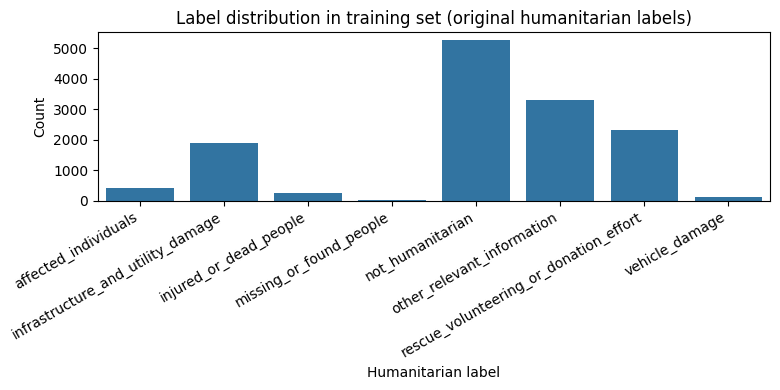

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("< Label counts in train set (by label_name) >")
label_counts = train_df["label_name"].value_counts().reindex(label_names)
print(label_counts)

plt.figure(figsize=(8, 4))
sns.countplot(x="label_name", data=train_df, order=label_names)
plt.title("Label distribution in training set (original humanitarian labels)")
plt.xlabel("Humanitarian label")
plt.ylabel("Count")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


## **2-e. Tweet length distribution (characters and words)**
By examining the tweet length in characters and words, we can understand how long the texts typically are. This helps determine:
* Whether any tweets are too short or too noisy (e.g., 1–2 words)
* How long the inputs usually are, so we can set an appropriate tokenizer max_length for BERT/DistilBERT
* avoid unnecessary truncation

**1. Character length summary**
* Mean ≈ 117, Minimum = 38, Maximum = 182 characters
* Most tweets fall between 100–140 characters

**2. Word length summary**
* Mean ≈ 14, and 75% are under 16 words
* Maximum = 26 words → In terms of BERT tokens, this is quite short (≈ 15–35 tokens). This means a max_length = 64 is enough.

**Overall**, tweets in this dataset are short and consistent in length, so using a DistilBERT tokenizer with max_length = 64 will safely cover nearly all examples, while also keeping the model efficient.

< Text length (characters) summary >
count    13608.000000
mean       117.479424
std         20.030839
min         38.000000
25%        106.000000
50%        122.000000
75%        134.000000
max        182.000000
Name: text_len_char, dtype: float64


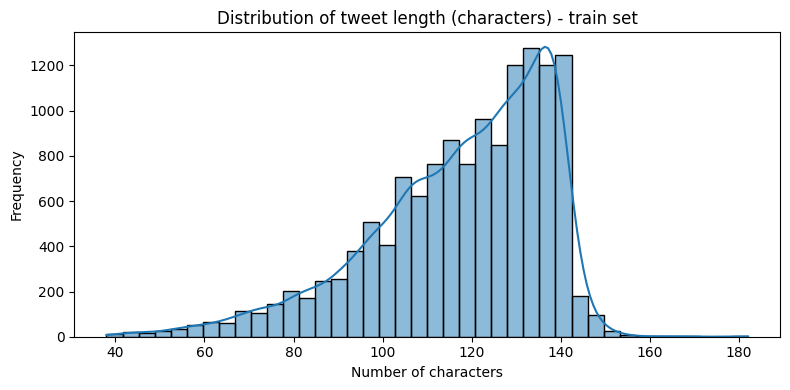


< Text length (words) summary >
count    13608.000000
mean        13.853175
std          3.624860
min          4.000000
25%         11.000000
50%         14.000000
75%         16.000000
max         26.000000
Name: text_len_word, dtype: float64


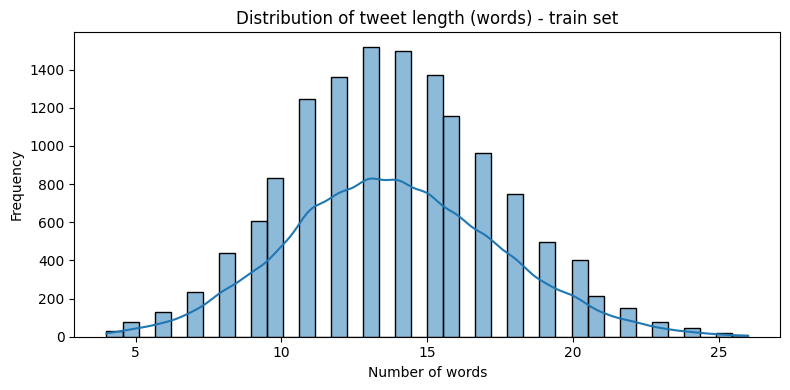

In [ ]:
# Character length summary
train_df["text_len_char"] = train_df["tweet_text"].astype(str).str.len()

print("< Text length (characters) summary >")
print(train_df["text_len_char"].describe())

plt.figure(figsize=(8, 4))
sns.histplot(train_df["text_len_char"], bins=40, kde=True)
plt.title("Distribution of tweet length (characters) - train set")
plt.xlabel("Number of characters")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Word length summary
train_df["text_len_word"] = train_df["tweet_text"].astype(str).str.split().str.len()

print("\n< Text length (words) summary >")
print(train_df["text_len_word"].describe())

plt.figure(figsize=(8, 4))
sns.histplot(train_df["text_len_word"], bins=40, kde=True)
plt.title("Distribution of tweet length (words) - train set")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()



=========================================================================================================

# **3. Preprocessing**
From the EDA above, I will apply the following preprocessing steps:
1. Create a text-only view of the dataset (drop image-related fields).
2. Remap the original humanitarian labels to a 4-level military-inspired severity scale:
* `Routine` / `Elevated` / `Urgent` / `Critical`
(Will be explained more below.)
3. Drop extremely short tweets (e.g., 1–2 words) because they are mostly noise.
4. Handle class imbalance via:
* `class_weight="balanced"` for the TF–IDF + Logistic Regression baseline, and cost-sensitive evaluation + lexicon-weighted oversampling for the Transformer model.


## **3-a. Data Cleaning : Create a text-only version of the dataset**
Image-related columns are dropped and we keep only the columns needed for text classification:
* tweet_text   : input text
* label_name   : original humanitarian label (string)
* label        : original humanitarian label id (int)



In [ ]:
text_cols = ["tweet_text", "label", "label_name"]

train_text_df = train_df[text_cols].copy()
valid_text_df = valid_df[text_cols].copy()
test_text_df  = test_df[text_cols].copy()

print("<Text-only dataset shapes>")
print("Train:", train_text_df.shape)
print("Valid:", valid_text_df.shape)
print("Test :", test_text_df.shape)


<Text-only dataset shapes>
Train: (13608, 3)
Valid: (2237, 3)
Test : (2237, 3)


## **3-b. Severity Mapping**
### **📌Severity mapping: design and rationale**

The original CrisisMMD humanitarian labels are designed as **information types**, not as an ordered severity scale. In this project, we reinterpret them as a <font color="OrangeRed"><b> 4-level operational severity variable:</b></font>

* <font color="OrangeRed"><b> **Routine**</b></font>
  * `not_humanitarian`, `other_relevant_information`
* <font color="OrangeRed"><b> **Elevated**</b></font>
  * `infrastructure_and_utility_damage`, `vehicle_damage`, `rescue_volunteering_or_donation_effort`
* <font color="OrangeRed"><b>**Urgent**</b></font>
  * `affected_individuals`
* <font color="OrangeRed"><b>**Critical**</b></font>
  * `injured_or_dead_people`, `missing_or_found_people`

This design is inspired by (but does not copy exactly as written) existing multi-level urgency scales used in military and medical practice:

* <font color="OrangeRed"><b>**Military medical evacuation precedence**:</b></font>
   U.S. casualty evacuation doctrine typically assigns patients to categories such as **Urgent / Urgent-Surgical / Priority / Routine (± Convenience)** based on how quickly evacuation is required.
   
   These categories explicitly distinguish routine cases from time-critical ones, providing a conceptual basis for separating **Routine/Elevated** from **Urgent/Critical** events in our scale.

* <font color="OrangeRed"><b>**Medical triage systems**:</b></font>
   Emergency department triage tools such as the **Emergency Severity Index (ESI)** use **5-level acuity scales** to stratify patients from immediately life-threatening (level 1) to least urgent (level 5).
   These systems show that real-world triage commonly uses **3–5 ordered levels of urgency**, distinguishing routine or low-acuity cases from urgent and critical threats.
   
* <font color="OrangeRed"><b>**“Elevated” readiness in naval medical guidance**:</b></font>
   Navy medical readiness guidance defines an **“Elevated” condition** as a state where there is an urgent requirement and staff must operate at a higher readiness level than in the routine state. ([med.navy.mil][3])
   This supports our use of **Elevated** as a mid-level category between background information and explicitly life-threatening events.

### **📌Why 4 levels, and why this grouping?**

From an **operational** and **data** perspective, four levels are a reasonable compromise:

* **Operationally**

  * `Routine / Elevated`: background or non–life-threatening reports (e.g., general information, infrastructure damage, support activities) that may require monitoring or resource adjustment but not immediate life-saving action.
  * `Urgent / Critical`: reports directly involving affected, injured, dead, or missing people, which are closer to the kinds of situations where **response procedures escalate** (e.g., rapid deployment, medical support, protection of routes or populations).

  Operationally, we think of `Routine`+`Elevated` as lower-severity (background / damage / support) and `Urgent`+`Critical` as higher-severity (people directly affected or life-threatening), and we implement this by mapping each original humanitarian label to one of the four levels as follows:
  * `Routine`: low urgency, background or non-humanitarian information
  * `Elevated`: damage, logistics, and support-related information
  * `Urgent`: people are affected, but not necessarily injured or dead
  * `Critical`: direct life-threatening situations (injury, death, missing)

* **EDA-based considerations**

  * Several original CrisisMMD labels (e.g., `missing_or_found_people`, `vehicle_damage`) are rare. If treated as separate classes, models tend to ignore them due to class imbalance.
  * By merging semantically related labels into shared severity levels (e.g., grouping `injured_or_dead_people` + `missing_or_found_people` into **`Critical`**), each class has enough samples for stable training while still preserving a clear **priority ordering** for decision-making.<br><br>

Overall, we **do not claim** that “`Routine`–`Elevated`–`Urgent`–`Critical`” is an official military doctrine. Instead:

* <font color="OrangeRed"><b>Align conceptually</b></font> with existing military evacuation precedence (Urgent / Priority / Routine) and clinical triage scales.
* Adapt these ideas to CrisisMMD by grouping labels along a <font color="OrangeRed"><b>**background → damage/support → affected individuals → life-threatening**</b></font> axis that is meaningful for emergency and military response.

※ Formal Reference
* V. Sanh, L. Debut, J. Chaumond, and T. Wolf, “DistilBERT, a
Distilled Version of BERT: Smaller, Faster, Cheaper and Lighter,”
arXiv:1910.01108, 2019
* N. Gilboy, T. Tanabe, D. Travers, and R. Wuerz, Emergency Severity
Index (ESI): A Triage Tool for Emergency Department Care, Version 4,
Implementation Handbook. Rockville, MD, USA: Agency for Healthcare
Research and Quality, 2005

### **3-b-1. Performance of Severity Mapping**

In [ ]:
# Define the mapping from original label_name -> severity level
label_to_severity = {
    # Routine: low urgency, background or non-humanitarian information
    "not_humanitarian": "Routine",
    "other_relevant_information": "Routine",

    # Elevated: damage, logistics, and support-related information
    "infrastructure_and_utility_damage": "Elevated",
    "vehicle_damage": "Elevated",
    "rescue_volunteering_or_donation_effort": "Elevated",

    # Urgent: people are affected, but not necessarily injured or dead
    "affected_individuals": "Urgent",

    # Critical: direct life-threatening situations (injury, death, missing)
    "injured_or_dead_people": "Critical",
    "missing_or_found_people": "Critical",
}

# Define an ordered severity scale (for consistent encoding)
severity_order = ["Routine", "Elevated", "Urgent", "Critical"]
severity_to_id = {sev: i for i, sev in enumerate(severity_order)}
id_to_severity = {i: sev for sev, i in severity_to_id.items()}

# Apply the mapping to each split
def add_severity_column(df):
    """
    Add a new column 'severity_label' based on 'label_name',
    and also create an integer-encoded 'severity_id' for modeling.
    """
    # Map label_name -> severity string
    df = df.copy()
    df["severity_label"] = df["label_name"].map(label_to_severity)

    # Check for any unmapped labels (should be None if mapping is complete)
    if df["severity_label"].isna().any():
        print("Warning: Some labels were not mapped to severity:")
        print(df.loc[df["severity_label"].isna(), "label_name"].value_counts())

    # Map severity_label -> severity_id (0~3)
    df["severity_id"] = df["severity_label"].map(severity_to_id)

    return df

# Apply to train/valid/test
train_sev_df = add_severity_column(train_text_df)
valid_sev_df= add_severity_column(valid_text_df)
test_sev_df= add_severity_column(test_text_df)

print("< Severity mapping dictionaries >")
print("severity_to_id:", severity_to_id)
print("id_to_severity:", id_to_severity)


< Severity mapping dictionaries >
severity_to_id: {'Routine': 0, 'Elevated': 1, 'Urgent': 2, 'Critical': 3}
id_to_severity: {0: 'Routine', 1: 'Elevated', 2: 'Urgent', 3: 'Critical'}


### **3-b-2. Severity distribution after mapping**
* Check how many examples fall into each severity level

< Severity counts in training set >
severity_label
Routine     8554
Elevated    4362
Urgent       424
Critical     268
Name: count, dtype: int64


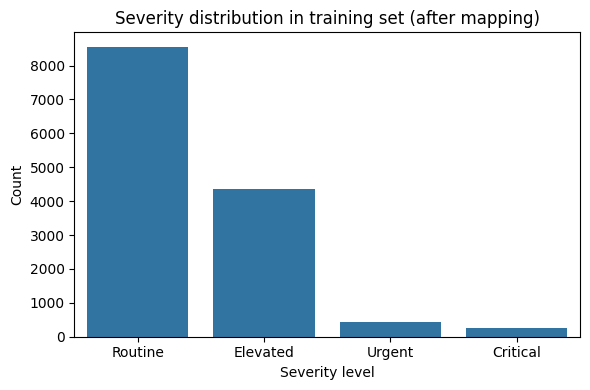

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Print Frequency table
print("< Severity counts in training set >")
sev_counts = train_sev_df["severity_label"].value_counts()
print(sev_counts)

# Reindex to enforce a fixed logical order
severity_order = ["Routine", "Elevated", "Urgent", "Critical"]
sev_counts = sev_counts.reindex(severity_order)

# Plot a bar chart of the severity distribution
plt.figure(figsize=(6, 4))
sns.barplot(
    x=sev_counts.index,
    y=sev_counts.values
)
plt.title("Severity distribution in training set (after mapping)")
plt.xlabel("Severity level")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

=========================================================================================================

# **4. Baseline Model: TF–IDF + Logistic Regression**

## **4-a. Import library**
* TfidfVectorizer: text → TF-IDF features
* LogisticRegression: multiclass classifier
* metrics: evaluation (accuracy, F1, classification report, confusion matrix)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt


## **4-b. Prepare text and labels for TF-IDF baseline**
Currently the data is in pandas Series, so we convert the text and label columns into NumPy arrays to ensure compataibility with scikit-learn's TF-IDF vectorizer and Logistic Regression training.

※ Note
* `tweet_text`: raw tweet text
* `severity_to_id`: {'Routine': 0, 'Elevated': 1, 'Urgent': 2, 'Critical': 3}

In [ ]:
# Converting text data into Numpy arrays
X_train_text = train_sev_df["tweet_text"].astype(str).values
X_valid_text = valid_sev_df["tweet_text"].astype(str).values
X_test_text  = test_sev_df["tweet_text"].astype(str).values

# Converting Integer labels into Numpy arrays
y_train = train_sev_df["severity_id"].values
y_valid = valid_sev_df["severity_id"].values
y_test  = test_sev_df["severity_id"].values

## **4-c. Fit TF-IDF vectorizer on training text**
Then, we vectorize text into TF-IDF features for training, validation, and test sets.

In [ ]:
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),    # unigrams + bigrams
    min_df=2,              # appear in at least 2 documents
    max_features=10000,    # cap vocabulary size (max_features=10,000)
    lowercase=True,
)

# Learn vocabulary on training set and transform train/valid/test
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_valid_tfidf = tfidf_vectorizer.transform(X_valid_text)
X_test_tfidf  = tfidf_vectorizer.transform(X_test_text)


## **4-d. Train Logistic Regression baseline model**
* Multinomial logistic regression for 4 severity classes
* Class imbalance handled by `class_weight="balanced"`

In [ ]:
logreg_baseline = LogisticRegression(
    multi_class="multinomial",  # Use multinomial (softmax) for multi-classification
    solver="lbfgs",
    class_weight="balanced",    # Adjust weights to handle imbalanced severity classes
    max_iter=1000,              # Maximum number of iterations to ensure convergence during training
    n_jobs=-1,
    random_state=42,            # Fit random seed for reproducibility of results
)

logreg_baseline.fit(X_train_tfidf, y_train)



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', n_jobs=-1, random_state=42)

## **4-e. Cost-Sensitive Matrix for Evaluation**
### **📌What is Cost-Sensitive Matrix?**

A cost-sensitive matrix is a user-defined table that assigns different penalties to different types of misclassification.
Unlike standard metrics, which treat all errors equally, a <font color="OrangeRed"><b>cost-sensitive matrix</b></font> allows the evaluation to <font color="OrangeRed"><b>prioritize certain types of mistakes over others</b></font> based on real-world consequences.

However, there is **no universal or built-in cost matrix** for CrisisMMD, DistilBERT, or classification models in general. It's because the **severity** of misclassification is highly domain-dependent:

<font color="OrangeRed"><b>In military or crisis response, misclassifying a "critical" event as "routine" is far more dangerous than overestimating a routine message.</b></font>

In this project, I <font color="OrangeRed"><b>customize a cost-sensitive evaluation matrix</b></font> to reflect operational risks that cannot be captured by standard accuracy or F1 metrics.



### **📌Necessity of Cost-Sensitive Matrix**
Because CrisisMMD is a civilian humanitarian dataset, it does not naturally encode these military operational priorities.

The cost matrix allows the model evaluation to approximate the **decision-making realities of a military command environment**, where underestimating severity is significantly more harmful than overestimating it.

In crisis and defense settings, the cost of an error is not symmetric:

* <font color="OrangeRed"><b>**False Negative on Critical (Critical → Routine or Elevated)**</b></font>
  → Potential mission failure, delayed rescue, or threat escalation.
  → **highest penalty**.

* <font color="OrangeRed"><b>**False Negative on Urgent (Urgent → Routine)**</b></font>
  → High operational risk → **large penalty**.

* <font color="OrangeRed"><b>**Confusion within mid-range classes (Elevated ↔ Urgent)**</b></font>
  → Moderately important → **medium penalty**.

* <font color="OrangeRed"><b>**False Positive (Routine → Critical)**</b></font>
  → Causes unnecessary attention or resource allocation → **lower penalty**.

### **4-e-1. Defining Cost-Sensitive Matrix**
Cost-Sensitive Matrix (true_label = row, predicted_label = column)

We define a cost-sensitive matrix as a 4×4 table:
  * Rows = true severity class
  * Columns = predicted severity class
  * Value = penalty (risk) of that specific error

Correct predictions recieve zero cost:
  * diagonal = 0

Misclassifications accumulate cost proportional to their operational risk
  * true Critical → predicted Routine : 5.0 (It's the worst mistake.)
  * true Critical → predicted Elevated : 4.0
  * true Urgent → predicted Routine : 3.0
  * true Routine → predicted Critical : 4.0
    (It's a false alarm, but nevertheless a fairly expensive mistake.)

In [ ]:
import numpy as np

cost_matrix = np.array([
# pred: R     E     U     C
    [ 0.0,  1.0,  3.0,  4.0],  # true Routine
    [ 1.0,  0.0,  2.0,  4.0],  # true Elevated
    [ 3.0,  2.0,  0.0,  2.5],  # true Urgent
    [ 5.0,  4.0,  2.5,  0.0],  # true Critical
])

### **4-e-2. Define Cost-Sensitive risk function**

Given a set of model predictions, we can turn the cost matrix into a scalar risk score.  

For each sample \(k\),
we look up the corresponding cost: cost_k = Cost_Matrix[y_true[k], y_pred[k]]

<br>

We then define:

* **Total risk**: `TotalRisk` = ∑cost_k (k=1..N)

* **Average risk per sample**: `AvgRisk` = (1 / N)*∑cost_k (k=1..N)

This gives a complementary performance signal alongside accuracy and F1 scores, showing  
**how dangerous a model’s mistakes are** under our domain-specific priorities.

In [ ]:
def compute_cost_sensitive_risk(y_true, y_pred, cost_matrix):
    """
    Compute cost-sensitive risk based on a given cost matrix.

    < Parameters >
    y_true : array-like, shape (n_samples,)
        - True integer labels (0~3).
    y_pred : array-like, shape (n_samples,)
        - Predicted integer labels (0~3).
    cost_matrix : np.ndarray, shape (n_classes, n_classes)
        - cost_matrix[i, j] = cost of predicting class j when true class is i.

    < Returns >
    avg_risk : float
        - Average cost per sample.
    total_risk : float
        - Sum of costs over all samples.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Cost for each sample is given by cost_matrix[true_label, pred_label]
    sample_costs = cost_matrix[y_true, y_pred]

    avg_risk = sample_costs.mean()
    total_risk = sample_costs.sum()

    return avg_risk, total_risk

## **4-f. Evaluation of Logistic Regression Baseline model**
We make an evaluation helper function that:
* Computes accuracy and macro-F1
* Prints classification reports
* Plots confusion matrices & cost-sensitive risk matrices.

This function is applied to assess the baseline model on both the validation and test sets.

 < Validation performance >
Accuracy  : 0.6522
Macro F1  : 0.4678

Avg Risk   : 0.5814
Total Risk : 1300.50

              precision    recall  f1-score   support

     Routine      0.828     0.700     0.759      1494
    Elevated      0.500     0.583     0.538       626
      Urgent      0.145     0.310     0.197        71
    Critical      0.283     0.565     0.377        46

    accuracy                          0.652      2237
   macro avg      0.439     0.540     0.468      2237
weighted avg      0.703     0.652     0.671      2237



<Figure size 500x400 with 0 Axes>

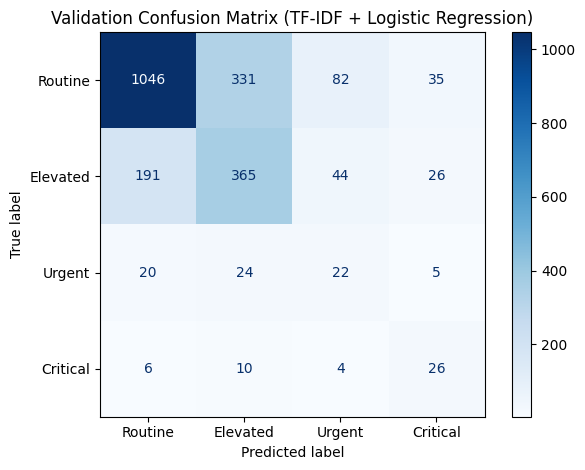

 < Test performance >
Accuracy  : 0.6455
Macro F1  : 0.4722

Avg Risk   : 0.5849
Total Risk : 1308.50

              precision    recall  f1-score   support

     Routine      0.803     0.713     0.755      1427
    Elevated      0.525     0.560     0.542       678
      Urgent      0.099     0.186     0.130        86
    Critical      0.357     0.652     0.462        46

    accuracy                          0.646      2237
   macro avg      0.446     0.528     0.472      2237
weighted avg      0.682     0.646     0.661      2237



<Figure size 500x400 with 0 Axes>

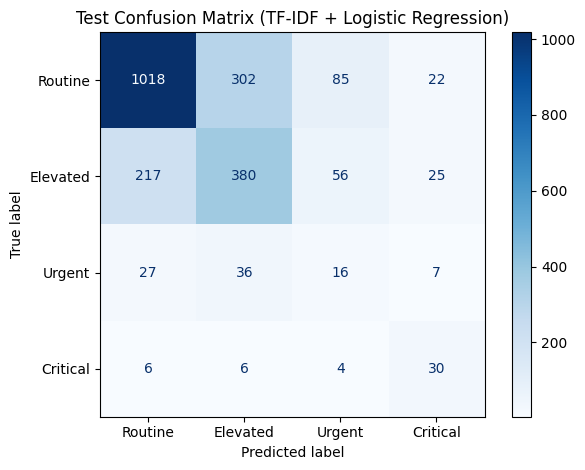

In [ ]:
def evaluate_baseline(model, X, y_true, split_name="Valid"):

    y_pred = model.predict(X)

    accuracy = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")

    # Cost-sensitive risk
    avg_risk, total_risk = compute_cost_sensitive_risk(y_true, y_pred, cost_matrix)

    print(f" < {split_name} performance >")
    print(f"Accuracy  : {accuracy:.4f}")
    print(f"Macro F1  : {macro_f1:.4f}\n")
    print(f"Avg Risk   : {avg_risk:.4f}")
    print(f"Total Risk : {total_risk:.2f}\n")

    # Detailed classification report with severity names
    target_names = severity_order
    print(classification_report(y_true, y_pred, target_names=target_names, digits=3))

    # Confusion matrix
    confusion_mat = confusion_matrix(y_true, y_pred, labels=range(len(severity_order)))

    confusion_mat_disp = ConfusionMatrixDisplay(
        confusion_matrix=confusion_mat,
        display_labels=severity_order,
    )
    plt.figure(figsize=(5, 4))
    confusion_mat_disp.plot(cmap="Blues", values_format="d")
    plt.title(f"{split_name} Confusion Matrix (TF-IDF + Logistic Regression)")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()

# Validation performance
evaluate_baseline(logreg_baseline, X_valid_tfidf, y_valid, split_name="Validation")
# Test performance
evaluate_baseline(logreg_baseline, X_test_tfidf, y_test, split_name="Test")


=========================================================================================================

# **5. Transformers Model: DistilBERT + AutoTokenizer**

## **5-a. DistilBERT: Tokenizer & Dataset Preparation**

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, set_seed

import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Set random seed for reproducibility
set_seed(42)

# DistilBERT tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Convert pandas → HF Dataset (enable efficient tokenization and Trainer-based model training)
def df_to_hf_dataset(df):
    hf_dataset = Dataset.from_pandas(df[["tweet_text", "severity_id"]])
    hf_dataset = hf_dataset.rename_column("tweet_text", "text")
    hf_dataset = hf_dataset.rename_column("severity_id", "labels")
    return hf_dataset

train_hf = df_to_hf_dataset(train_sev_df)
valid_hf = df_to_hf_dataset(valid_sev_df)
test_hf  = df_to_hf_dataset(test_sev_df)

# Tokenization function for batches
def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",  # pad to fixed length
        truncation=True,       # cut off texts longer than max_length
        max_length=64,         # from EDA, we choose 64 tokens as max_length
    )

# Apply tokenization
train_enc = train_hf.map(tokenize_batch, batched=True)
valid_enc = valid_hf.map(tokenize_batch, batched=True)
test_enc  = test_hf.map(tokenize_batch,  batched=True)

# Drop the raw text and index columns, keeping only tensors
cols_to_remove = ["text"]
for name in ["__index_level_0__", "_index"]:
    if name in train_enc.column_names:
        cols_to_remove.append(name)

train_enc = train_enc.remove_columns(cols_to_remove)
valid_enc = valid_enc.remove_columns(cols_to_remove)
test_enc  = test_enc.remove_columns(cols_to_remove)

# Set format from Arrow Hugging Face Dataset to PyTorch tensors (for Trainer)
train_enc.set_format("torch")
valid_enc.set_format("torch")
test_enc.set_format("torch")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/13608 [00:00<?, ? examples/s]

Map:   0%|          | 0/2237 [00:00<?, ? examples/s]

Map:   0%|          | 0/2237 [00:00<?, ? examples/s]

## **5-b. DistilBERT Model Setup and Training Configuration**

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# Initialize a DistilBERT sequence classification model with 4 output labels (severity levels 0–3).
num_labels = 4

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
)

# Define Metric function to compute accuracy and macro-F1 for evaluation (used by Trainer).
def compute_metrics(eval_pred):

    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average="macro")

    return {
        "accuracy": accuracy,
        "macro_f1": macro_f1,
    }

# Setting TrainingArguments
training_args = TrainingArguments(
    output_dir="./crisismmd_distilbert_severity",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none"
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_enc,
    eval_dataset=valid_enc,
    compute_metrics=compute_metrics,
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **5-c. Training DistilBERT**

In [ ]:
train_result = trainer.train()
print(train_result)

Step,Training Loss
500,0.733900
1000,0.642200
1500,0.576900
2000,0.518100
2500,0.480000


TrainOutput(global_step=2553, training_loss=0.5876281430475674, metrics={'train_runtime': 251.1802, 'train_samples_per_second': 162.529, 'train_steps_per_second': 10.164, 'total_flos': 676005245669376.0, 'train_loss': 0.5876281430475674, 'epoch': 3.0})


In [ ]:
# Save DistilBERT baseline
baseline_dir = "/content/crisis_distilbert_baseline"
trainer.save_model(baseline_dir)

# zip
!zip -r /content/crisis_distilbert_baseline.zip /content/crisis_distilbert_baseline

  adding: content/crisis_distilbert_baseline/ (stored 0%)
  adding: content/crisis_distilbert_baseline/training_args.bin (deflated 53%)
  adding: content/crisis_distilbert_baseline/config.json (deflated 50%)
  adding: content/crisis_distilbert_baseline/model.safetensors (deflated 8%)


## **5-d. Evaluate DistilBERT on validation and test sets**
We apply the same metrics used for TD-IDF + Logistic Regression model.
<br>
(Accuracy, Macro F1, classification report, confusion matrix, cost-sensitive risk)

< Validation performance (DistilBERT) >
Accuracy  : 0.7179
Macro F1  : 0.5285

Avg Risk   : 0.4066
Total Risk : 909.50

Classification report:
              precision    recall  f1-score   support

     Routine      0.820     0.795     0.807      1494
    Elevated      0.546     0.607     0.575       626
      Urgent      0.314     0.155     0.208        71
    Critical      0.474     0.587     0.524        46

    accuracy                          0.718      2237
   macro avg      0.538     0.536     0.529      2237
weighted avg      0.720     0.718     0.717      2237



<Figure size 500x400 with 0 Axes>

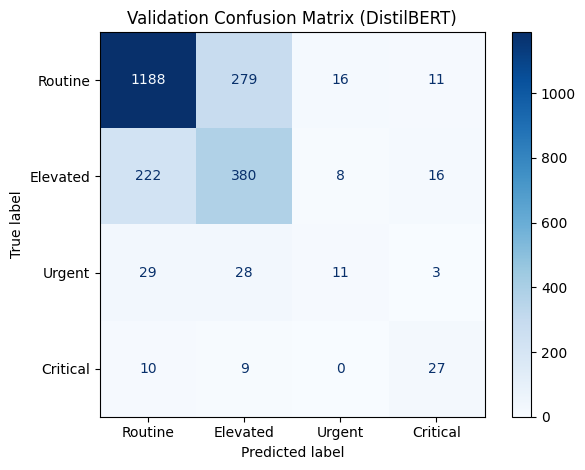

< Test performance (DistilBERT) >
Accuracy  : 0.7032
Macro F1  : 0.5221

Avg Risk   : 0.4213
Total Risk : 942.50

Classification report:
              precision    recall  f1-score   support

     Routine      0.785     0.805     0.795      1427
    Elevated      0.565     0.566     0.566       678
      Urgent      0.290     0.105     0.154        86
    Critical      0.500     0.674     0.574        46

    accuracy                          0.703      2237
   macro avg      0.535     0.538     0.522      2237
weighted avg      0.693     0.703     0.696      2237



<Figure size 500x400 with 0 Axes>

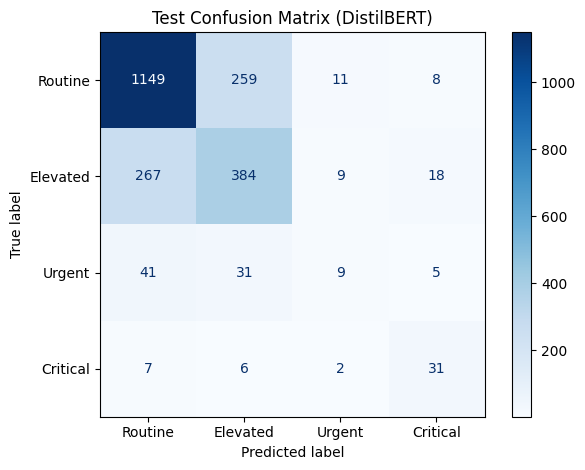

In [ ]:
def evaluate_distilbert_on_dataset(encoded_ds, split_name="Valid"):

    pred_output = trainer.predict(encoded_ds)
    y_true = pred_output.label_ids
    y_pred = np.argmax(pred_output.predictions, axis=-1)

    # Cost-sensitive risk
    avg_risk, total_risk = compute_cost_sensitive_risk(y_true, y_pred, cost_matrix)

    # Accuracy & Macro-F1
    accuracy = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")

    print(f"< {split_name} performance (DistilBERT) >")
    print(f"Accuracy  : {accuracy:.4f}")
    print(f"Macro F1  : {macro_f1:.4f}\n")
    print(f"Avg Risk   : {avg_risk:.4f}")
    print(f"Total Risk : {total_risk:.2f}\n")

    # Per-class report
    target_names = severity_order
    print("Classification report:")
    print(
        classification_report(
            y_true,
            y_pred,
            target_names=target_names,
            digits=3,
        )
    )

    # Confusion matrix
    confusion_mat = confusion_matrix(y_true, y_pred, labels=range(len(severity_order)))
    confusion_mat_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=severity_order)

    plt.figure(figsize=(5, 4))
    confusion_mat_disp.plot(cmap="Blues", values_format="d")
    plt.title(f"{split_name} Confusion Matrix (DistilBERT)")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()

# Validation Performance
evaluate_distilbert_on_dataset(valid_enc, split_name="Validation")
# Test Performance
evaluate_distilbert_on_dataset(test_enc, split_name="Test")


=========================================================================================================

# **6. DistilBERT + Domain Adaptation**
### **📌What is Domain Adaptation?**
Domain adaptation refers to techniques that shift a general-purpose model toward a specific operational domain, without requiring new labeled data.
In this project, the goal is to bias DistilBERT toward defense/logistics-related crisis language, so that the model becomes more sensitive to high-severity messages that are militarily relevant.
In other words:
* **We do not change the model architecture,**
* **We change the distribution of training samples to emphasize the domain of interest.**

<font color="OrangeRed"><b>This allows the **severity classifier to pay more attention to messages that resemble military situation reports**</b></font>, even though the dataset itself is humanitarian (CrisisMMD).

### **📌Necessity of Domain Adaptation**
Commanders and operations centers receive massive amounts of mixed information:
news updates, social media reports, civilian emergency data, and internal military reports.

Not every incident requires a military response; many belong to police, fire, or municipal authorities.
However, some events do require military involvement (e.g., threats to logistics routes, convoy safety, base security, large-scale population protection).

<font color="OrangeRed"><b>In such an environment, a decision-support model must be able to: simultaneously recognize whether an event is relevant to military logistics/operations and estimate severity (Routine ~ Critical).</b></font>

A generic DistilBERT baseline(which we just tested before) is trained to optimize overall performance across all tweets.
<font color="OrangeRed"><b>It has no reason to pay special attention to **logistics terms** (e.g., “convoy”, “supply route”), **sustainment and movement terms** (e.g., “fuel depot”, “bridge destroyed”), **unit or operation cues** (e.g., “brigade”, “checkpoint”, “munition”)</b></font>

Because such language is rare, a general model may miss or under-rank high-severity messages that are actually critical from an operational perspective.


### **📌How Domain Adaptation Is Applied (Lexicon-Weighted Oversampling)**

We apply **lexicon-weighted sampling**, a lightweight domain adaptation method:

<font color="OrangeRed"><b>**Step 1.**</b></font>
Build a custom defense-oriented lexicon

<font color="OrangeRed"><b>**Step 2.**</b></font>
Flag tweets that contain ≥1 defense-related term from the lexicon.

<font color="OrangeRed"><b>**Step 3.**</b></font>
Oversample these tweets during training (In this project, we duplicated 3 times). This increases their presence in the training distribution. In other words, minority samples are repeated to balance class exposure.

<font color="OrangeRed"><b>**Step 4.**</b></font>
Fine-tune DistilBERT without changing the architecture.

## **6-a. Build a Small Defense-oriented Lexicon**

The lexicon follows documented terminology from:

### **📌Military Logistics Doctrine**

* **NATO AJP-4 (Allied Joint Doctrine for Logistics)**: defines sustainment, supply, distribution, transportation, fuel/ammunition support.

* **JP 4-0 (U.S. Joint Logistics)**: defines movement, distribution networks, convoy operations, supply routes, depots.

* **NATO AJP-4.4 (Allied Joint Doctrine for Movement and Transportation)**: covers routes, mobility corridors, ports/airfields, vehicles, infrastructure.

### **📌Humanitarian + Disaster Logistics Literature**

* **Humanitarian Logistics in Disaster Relief (WIT Press)**: identifies critical logistics concepts: e.g., roads, bridges, warehouses, fuel, transport, distribution.

<font color="OrangeRed"><b>From these sources, we derive common cross-domain operational terms such as:</b></font>

* <font color="OrangeRed"><b>**Movement / Transportation**:</b></font> e.g., road, bridge, airport, port, route, convoy
* <font color="OrangeRed"><b>**Supply / Sustainment**:</b></font> e.g., fuel, ammo, ration, supplies, depot, warehouse
* <font color="OrangeRed"><b>**Vehicles / Equipment**:</b></font> e.g., truck, vehicle, armored, transport
* <font color="OrangeRed"><b>**Units / Security Context**:</b></font> e.g., unit, battalion, brigade, checkpoint

These are not classified terms; they are standard vocabulary across public NATO/DoD doctrine and humanitarian logistics research.

### **📌Goal of the Lexicon**

The lexicon is designed to identify tweets that reference:
* logistics infrastructure (road, bridge, port)
* movement or transport concerns (convoy, route)
* sustainment resources (fuel, supplies, depot)
* operational actors (unit, checkpoint, military activity)

These are precisely the contexts where a commander’s severity judgment affects:
* whether the military should respond at all, and
* what level of emergency procedure should be activated.

※ Formal References
* NATO Standardization Office, AJP-4: Allied Joint Doctrine for Logis-
tics. NATO Standardization Office, 2018.
(https://assets.publishing.service.gov.uk/media/68b999b811b4ded2da19fe37/ARCHIVE_AJP_4_logistics_EdB.pdf)
* Joint Chiefs of Staff, JP 4-0: Joint Logistics. U.S. Department of
Defense, 2019.
(https://www.bits.de/NRANEU/others/jp-doctrine/jp4_0%2813%29.pdf)
* NATO Standardization Office, AJP-4.4: Allied Joint Doctrine for Move-
ment and Transportation. NATO Standardization Office, 2013.
(https://www.coemed.org/files/stanags/01_AJP/AJP-4.4_EDC_V1_E_2506.pdf)
* P.~Tatham and L.~Houghton, ``The wicked problem of humanitarian logistics and disaster relief aid,''
\textit{Journal of Humanitarian Logistics and Supply Chain Management}, vol.~1, no.~1, pp.~15--31, 2011.

In [ ]:
# Step1. Build a custom defense-oriented lexicon

defense_lexicon = [
    # logistics / supply
    "supply", "supplies", "logistics", "convoy", "fuel", "ammo", "ammunition",
    "warehouse", "stockpile", "resupply", "distribution", "delivery",

    # infrastructure / transportation
    "bridge", "road", "highway", "port", "harbor", "rail", "railway",
    "airport", "runway", "dock", "power plant", "substation",

    # vehicles / equipment
    "truck", "vehicle", "tank", "armored", "fleet", "helicopter", "aircraft",
    "ship", "boat", "vessel", "equipment", "gear",

    # operations / command
    "base", "camp", "checkpoint", "patrol", "troops", "unit", "battalion",
    "brigade", "command", "hq", "headquarters", "mission", "operation",

    # emergency / response language that overlaps with military logistics
    "evacuation", "evacuate", "deployment", "mobilize", "relief convoy",
    "supply route", "aid convoy", "escort",
]


## **6-b. Flag tweets that contain lexicon terms**

In [ ]:
# Step2. Flag tweets that contain ≥1 defense-related term from the lexicon.
# train_sev_df (with 'tweet_text', 'severity_id')

def mark_defense_like_tweets(df, lexicon):
    """
    Add a boolean column 'has_defense_term' indicating whether
    the tweet text contains any of the defense-related keywords.
    """
    df = df.copy()

    # Lowercase lexicon once
    lexicon_lower = [term.lower() for term in lexicon]

    # Convert tweet text to lowercase strings
    texts = df["tweet_text"].astype(str).str.lower()

    # For each tweet, check if any lexicon term is a substring
    df["has_defense_term"] = texts.apply(
        lambda text: any(term in text for term in lexicon_lower)
    )

    return df

train_sev_marked = mark_defense_like_tweets(train_sev_df, defense_lexicon)

## **6-c. Oversample defense-like tweets to create domain-adapted train set**

In [ ]:
# Step 3. Oversample tweets and create a new domain-adapted training set

import pandas as pd

def make_lexicon_weighted_train_df(df_marked, oversample_factor=3):
    """
    Create a lexicon-weighted training DataFrame by oversampling
    tweets that contain defense-related terms.

    Oversampling is applied only to the training set,
    while the validation & test sets remain unchanged.

    < Parameters >
    df_marked : DataFrame
    Must contain:
        - 'tweet_text'
        - 'severity_id'
        - 'has_defense_term' (bool)
    oversample_factor : int
    How many extra copies of 'has_defense_term=True' rows to add.

   < Returns >
    augmented_train_df : DataFrame
    Augmented training DataFrame with oversampled defense-like tweets.
    """
    df = df_marked.copy()

    # Keep the original training set
    origin_train_df = df

    # Select only defense-like rows
    defense_df = df[df["has_defense_term"] == True]

    print(f"Original train size      : {len(origin_train_df)}")
    print(f"Defense-like tweet count : {len(defense_df)}")

    # Oversample defense-like rows
    if len(defense_df) > 0 and oversample_factor > 0:
        oversampled_parts = [defense_df] * oversample_factor
        augmented_train_df = pd.concat([origin_train_df] + oversampled_parts, ignore_index=True)
    else:
        augmented_train_df = origin_train_df

    print(f"Augmented train size : {len(augmented_train_df)}")

    return augmented_train_df

# A new Domain-adapted train set (with defense-like rows duplicated three times)
train_sev_da_df = make_lexicon_weighted_train_df(train_sev_marked, oversample_factor=3)

Original train size      : 13608
Defense-like tweet count : 3148
Augmented train size : 23052


## **6-d.  Domain-Adapted Version DistilBERT: Tokenizer & Dataset Preparation**
We follow the same prepartation steps as in the DistilBERT baseline(Section 5-a)

In [ ]:
# Step 4. Fine-tune DistilBERT : prepare dataset and tokenize

# Convert oversampled DataFrame to HF Dataset
train_da_hf = df_to_hf_dataset(train_sev_da_df)

# Apply the same tokenization function as in baseline DistilBERT
train_da_enc = train_da_hf.map(tokenize_batch, batched=True)

# Remove raw text / index columns so that only model inputs remain
cols_to_remove = []
for col in ["text", "__index_level_0__", "_index"]:
    if col in train_da_enc.column_names:
        cols_to_remove.append(col)

if cols_to_remove:
    train_da_enc = train_da_enc.remove_columns(cols_to_remove)

# Tell Datasets to return PyTorch tensors (for use with Trainer)
train_da_enc.set_format("torch")


Map:   0%|          | 0/23052 [00:00<?, ? examples/s]

## **6-e. Domain-Adapted DistilBERT Trainer**
We fresh the DistilBERT model for the domain-adapted version, then train the model with the same hyperparameters.

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# Fresh DistilBERT model for the domain-adapted variant
model_da = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
)

# Using the same hyperparameters as in DistilBERT baseline
training_args_da = TrainingArguments(
    output_dir="./crisismmd_distilbert_domain_adapted",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none"
)

trainer_da = Trainer(
    model=model_da,
    args=training_args_da,
    train_dataset=train_da_enc,  # oversampled domain-adapted train set
    eval_dataset=valid_enc,      # same validation set as in DistilBERT baseline
    compute_metrics=compute_metrics,
)

# Train domain-adapted DistilBERT
da_train_result = trainer_da.train()
print(da_train_result)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.767400
1000,0.621600
1500,0.555600
2000,0.442400
2500,0.406700
3000,0.368400
3500,0.299300
4000,0.290000


TrainOutput(global_step=4323, training_loss=0.455292870483822, metrics={'train_runtime': 423.1006, 'train_samples_per_second': 163.451, 'train_steps_per_second': 10.217, 'total_flos': 1145155270662144.0, 'train_loss': 0.455292870483822, 'epoch': 3.0})


## **6-f. Evaluate Domain-Adapted DistilBERT on validation and test sets**
We apply the same metrics used for the previous models.
<br>
(Accuracy, Macro F1, classification report, confusion matrix, cost-sensitive risk)

< Domain-adapted DistilBERT (lexicon-weighted) >


< Validation (Domain Adapted) performance (DistilBERT) >
Accuracy  : 0.7166
Macro F1  : 0.5147

Avg Risk   : 0.4164
Total Risk : 931.50

Classification report:
              precision    recall  f1-score   support

     Routine      0.822     0.790     0.806      1494
    Elevated      0.546     0.620     0.581       626
      Urgent      0.333     0.211     0.259        71
    Critical      0.413     0.413     0.413        46

    accuracy                          0.717      2237
   macro avg      0.529     0.509     0.515      2237
weighted avg      0.721     0.717     0.718      2237



<Figure size 500x400 with 0 Axes>

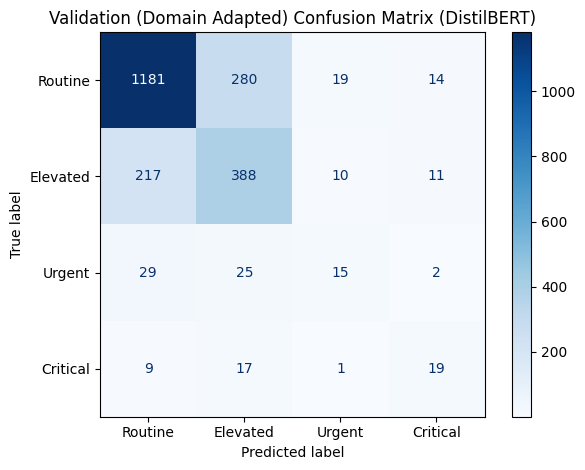

< Test (Domain Adapted) performance (DistilBERT) >
Accuracy  : 0.6853
Macro F1  : 0.4760

Avg Risk   : 0.4613
Total Risk : 1032.00

Classification report:
              precision    recall  f1-score   support

     Routine      0.780     0.783     0.781      1427
    Elevated      0.541     0.571     0.556       678
      Urgent      0.227     0.116     0.154        86
    Critical      0.413     0.413     0.413        46

    accuracy                          0.685      2237
   macro avg      0.490     0.471     0.476      2237
weighted avg      0.679     0.685     0.681      2237



<Figure size 500x400 with 0 Axes>

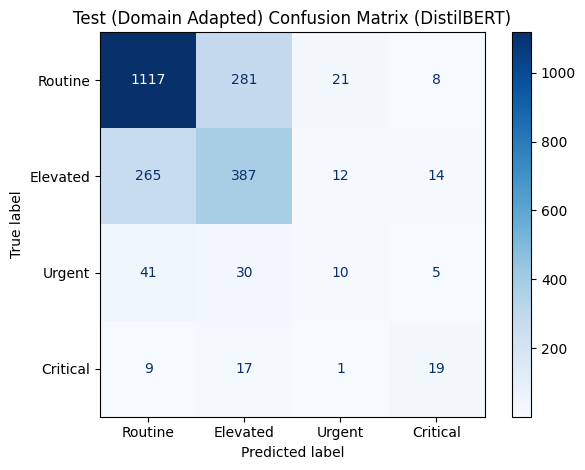

In [ ]:
# Temporarily switch global 'trainer' to the domain-adapted Trainer
trainer_backup = trainer   # save baseline trainer
trainer = trainer_da       # use domain-adapted trainer

print("< Domain-adapted DistilBERT (lexicon-weighted) >")
evaluate_distilbert_on_dataset(valid_enc, split_name="Validation (Domain Adapted)")
evaluate_distilbert_on_dataset(test_enc,  split_name="Test (Domain Adapted)")

# Restore the original baseline trainer
trainer = trainer_backup

In [ ]:
# Save Domain-adapted DistilBERT
da_dir = "/content/crisis_distilbert_domain_adapted"
trainer_da.save_model(da_dir)

# zip
!zip -r /content/crisis_distilbert_domain_adapted.zip /content/crisis_distilbert_domain_adapted

  adding: content/crisis_distilbert_domain_adapted/ (stored 0%)
  adding: content/crisis_distilbert_domain_adapted/training_args.bin (deflated 53%)
  adding: content/crisis_distilbert_domain_adapted/config.json (deflated 50%)
  adding: content/crisis_distilbert_domain_adapted/model.safetensors (deflated 8%)


## **※Summary of Results**

In [1]:
import pandas as pd

data = {
    "Model": [
        "TF-IDF + Logistic Reg.",
        "DistilBERT",
        "Domain-Adapted DistilBERT"
    ],
    "Accuracy": [0.6455, 0.7032, 0.6853],
    "Macro F1": [0.4722, 0.5221, 0.4760],
    "Avg Risk": [0.5849, 0.4213, 0.4613],
    "Total Risk": [1308.50, 942.50, 1032.00],
}

summary = pd.DataFrame(data)
print(summary)

                       Model  Accuracy  Macro F1  Avg Risk  Total Risk
0     TF-IDF + Logistic Reg.    0.6455    0.4722    0.5849      1308.5
1                 DistilBERT    0.7032    0.5221    0.4213       942.5
2  Domain-Adapted DistilBERT    0.6853    0.4760    0.4613      1032.0
